# Trends and Anomlaies in the Upwelling Indices

#### Climatologies (for UI<sub>Ek</sub>, UI<sub>SST</sub> and UI<sub>SSH</sub>)
1. Every week
    - trend, R2, p-value (whole period, last decade)
    - mean for every degree lat ?
2. Seasonal mean
    - trend, R2, p-value (whole period, last decade)
    - anomalies

In [1]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib
import cartopy.crs as ccrs
import os
import my_functions
import datetime
import statsmodels.api as sm
%matplotlib inline

In [17]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
LSM = xr.open_dataset('Land_sea_mask.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

## Data Prep

In [53]:
## calculate the UIs 
# UI Ek
MTSS['lsm'] = LSM.lsm
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm))

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})


In [59]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [316]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(SST)
UI_SST_summer = my_functions.subset_summer(UI_SST)
SSH_summer = my_functions.subset_summer(SSH)

## Functions

In [234]:
## plot variable, give stats over whole period and last decade

def plot_trend(x_dates, y, col = 'darkcyan', title = 'Title', ylabel = 'Y axis', save = False, save_fig_as = 'Test'):
    # get values for the trend line analysis
    fig = plt.figure(figsize = (9, 3))
    
    # calculate a fit line
    x_num = dates.date2num(x_dates)
    trend = np.polyfit(x_num, y, 1)
    fit = np.poly1d(trend)
    
    # calculate fitline only for past decade
    # define last decades in years
    last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 01/2021 - 12/2021
    
    # select last 10 years of data
    x_num_10 = np.delete(x_num, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]
    y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]
    
    trend_10 = np.polyfit(x_num_10, y_10, 1)
    fit_10 = np.poly1d(trend_10)
    
    # general plot again
    plt.plot(x_dates, y, marker = '.', markerfacecolor = col, alpha = 0.3, color = col)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.xlim(dates.date2num(['1980']), dates.date2num(['2025']))
    
    # get the input numbers for the fit line and convert the numbers back to dates
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "k-", alpha = 0.8, lw = 1, label = 'Trend') 
    
    # last 10 years
    x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
    plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", label = 'Trend last decade') 
    
    plt.legend(bbox_to_anchor=(1.0, 1), loc = 'upper left', labelspacing = 6.2, edgecolor = 'none', facecolor = 'none')
    plt.grid()
    plt.title(title)
    
    ## UI_Ek whole period SUMMER
    time = np.arange(0, len(x_dates))
    values = y.values
    time_with_const = sm.add_constant(time)
    model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    ## UI_Ek last decace SUMMER
    time = np.arange(0, len(x_num_10))
    values = y_10.values
    time_with_const = sm.add_constant(time)
    model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    plt.figtext(0.79, 0.2, r'  $R^2$:' f'{model_full.rsquared:.5f} \n  Trend: {model_full.params[1]:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\n\n\n' r'  $R^2$:' f'{model_10.rsquared:.5f} \n  Trend: {model_10.params[1]:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')
    
    fig.tight_layout()
    if save:
        fig.savefig(f'../Iberian_Coast_Upwelling/Figures/{save_fig_as}.png', dpi = 300, bbox_inches='tight')

## UI<sub>Ek</sub>

### UI<sub>Ek</sub> Trend

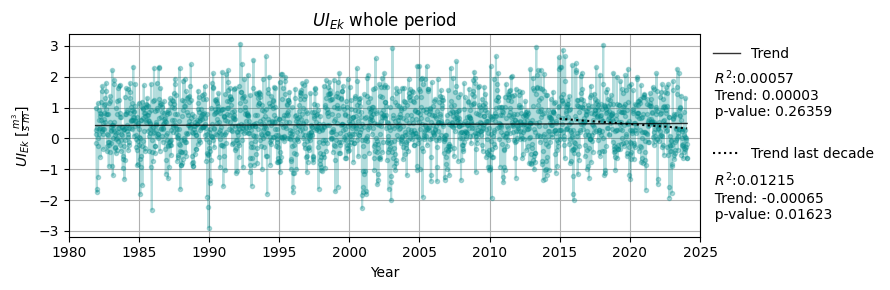

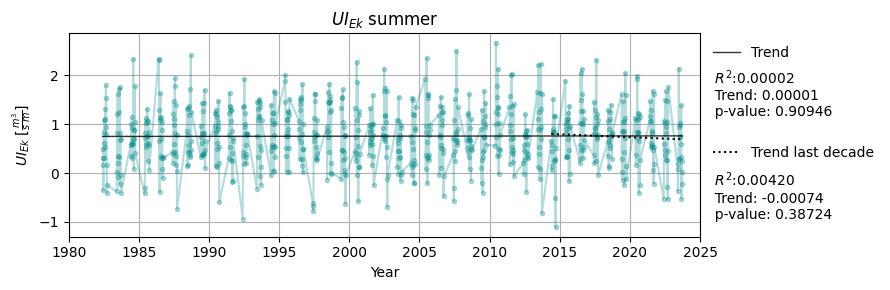

In [237]:
plot_trend(Ek.time, Ek.UI_mean, title = r'$UI_{Ek}$ whole period', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
plot_trend(Ek_summer.time, Ek_summer.UI_mean, title = r'$UI_{Ek}$ summer', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

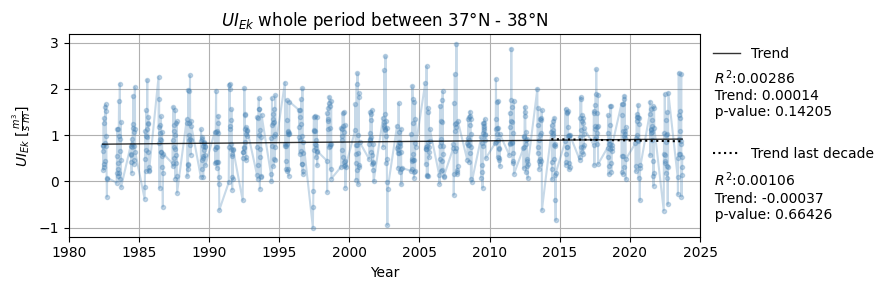

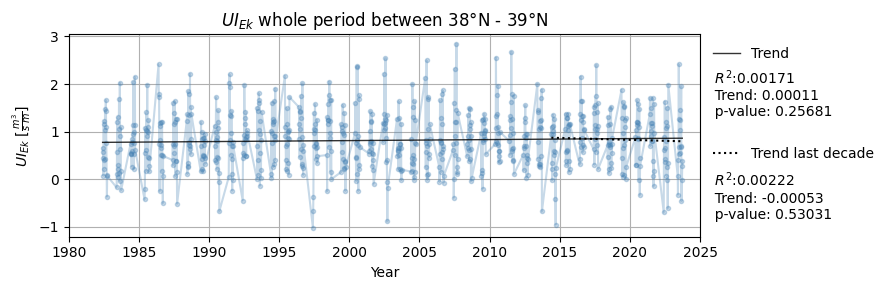

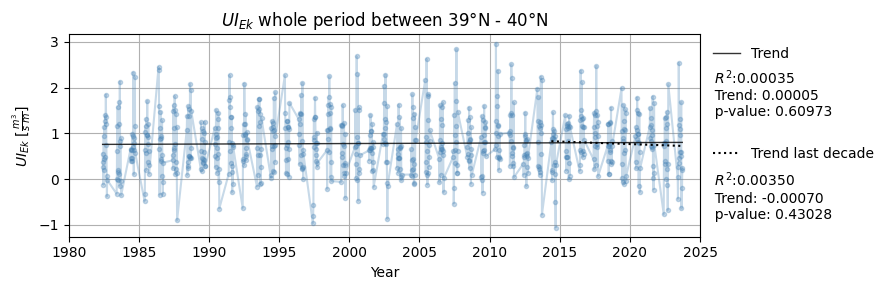

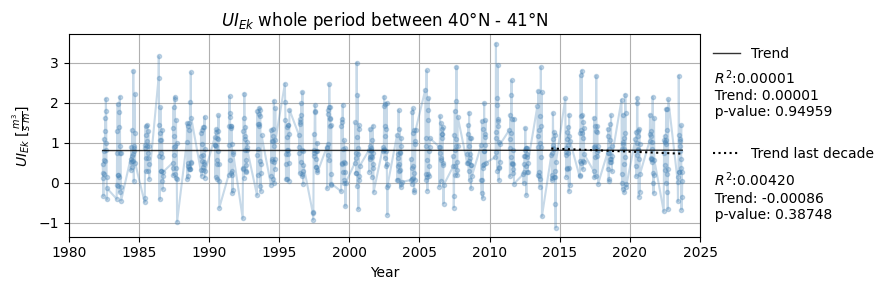

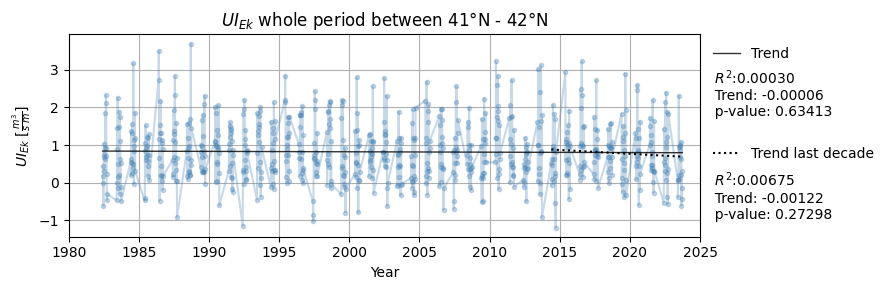

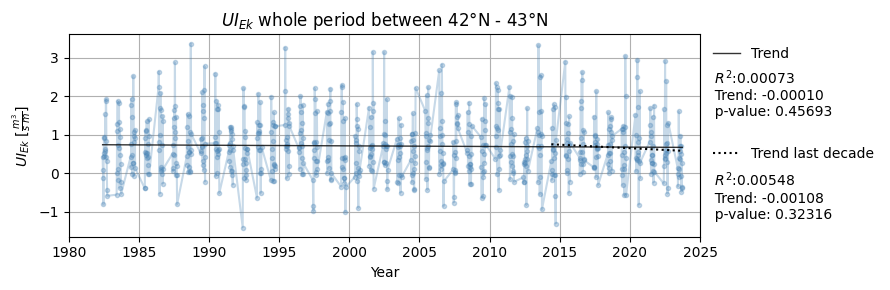

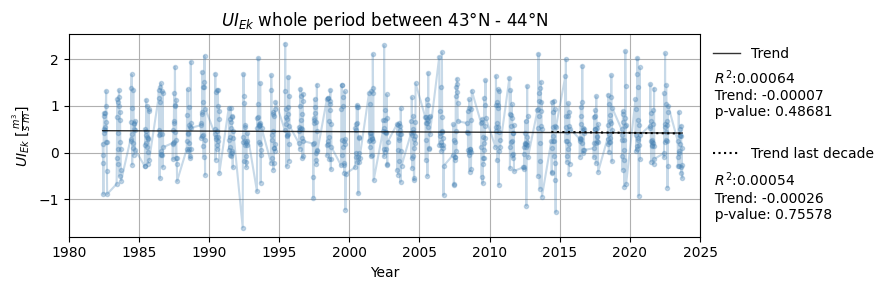

In [275]:
## the summer UI Ek for every degree lat (mean around that latitude)
for lats in np.arange(37, 44): # from 44°N coast has more of a SE-NW direction
    y = Ek_summer.UI.sel(lon = -10.5, method = 'nearest').sel(lat = slice(lats, lats+1)).mean(dim = 'lat')
    plot_trend(Ek_summer.time, y, col = 'steelblue', title = (r'$UI_{Ek}$ whole period' f' between {lats}°N - {lats + 1}°N'), ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$') 

### UI<sub>Ek</sub> Seasonal mean and anomalies

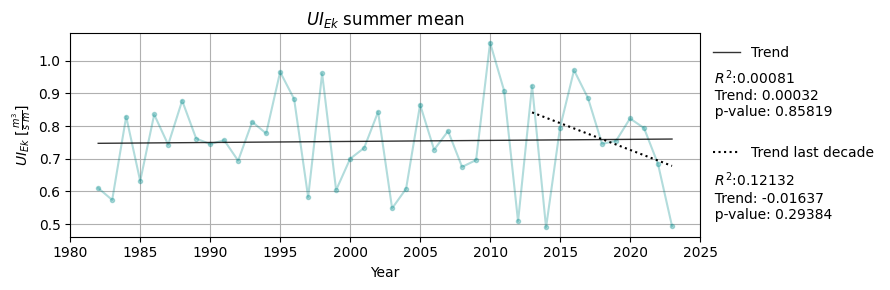

In [297]:
# calculate the mean over the summer months
Ek_summer_mean = Ek_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
plot_trend(Ek_summer_mean.time, Ek_summer_mean.UI_mean, title = r'$UI_{Ek}$ summer mean', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

Summer mean UI Ek 0.754


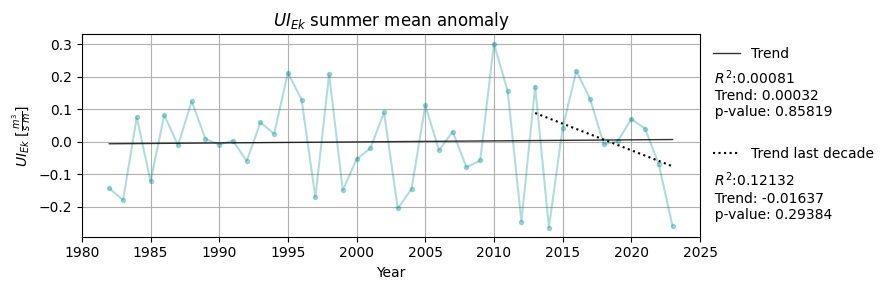

In [315]:
Ek_anomaly = Ek_summer_mean.UI_mean - Ek_summer_mean.UI_mean.mean(dim = 'time')
print('Summer mean UI Ek', np.round(Ek_summer_mean.UI_mean.mean(dim = 'time').values, 3))
plot_trend(Ek_summer_mean.time, Ek_anomaly, title = r'$UI_{Ek}$ summer mean anomaly', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

## UI<sub>SST</sub>

### UI<sub>SST</sub> Trend

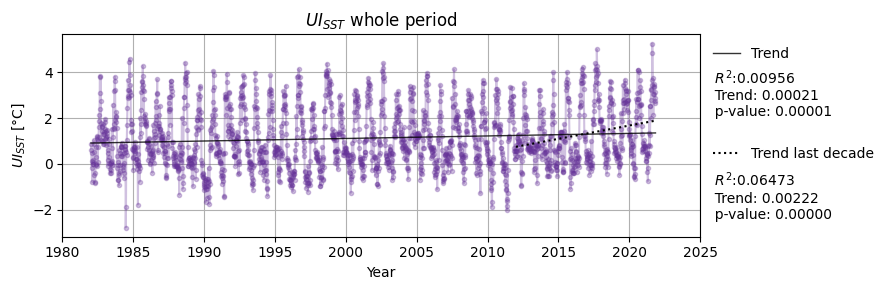

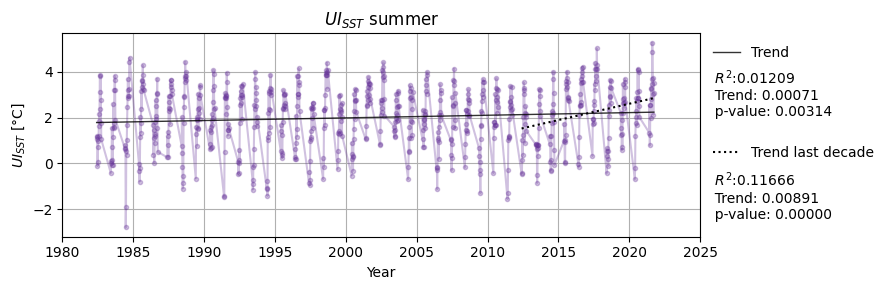

In [318]:
plot_trend(UI_SST.time, UI_SST.UI_mean, col = 'rebeccapurple',
           title = r'$UI_{SST}$ whole period', ylabel = r'$UI_{SST}$ [°C]')
plot_trend(UI_SST_summer.time, UI_SST_summer.UI_mean, col = 'rebeccapurple',
           title = r'$UI_{SST}$ summer', ylabel = r'$UI_{SST}$ [°C]')

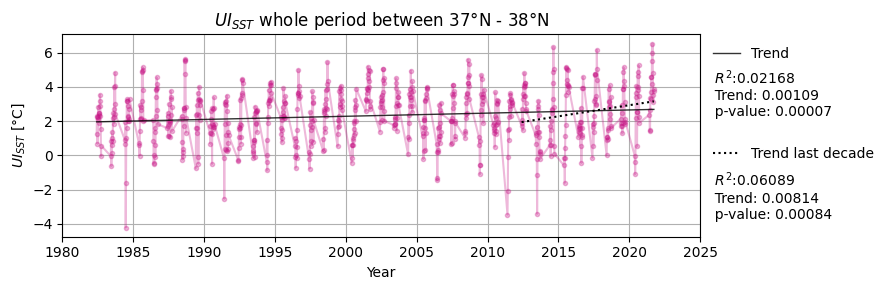

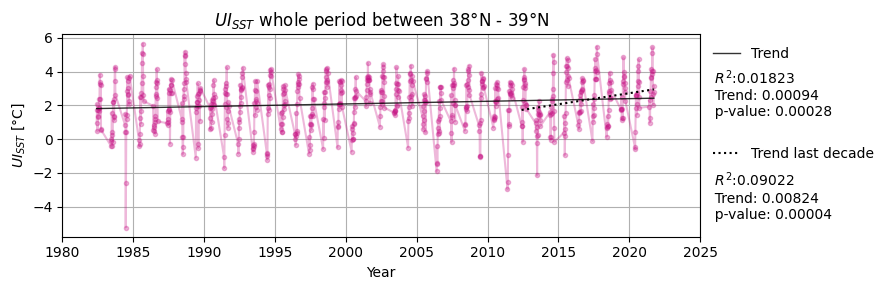

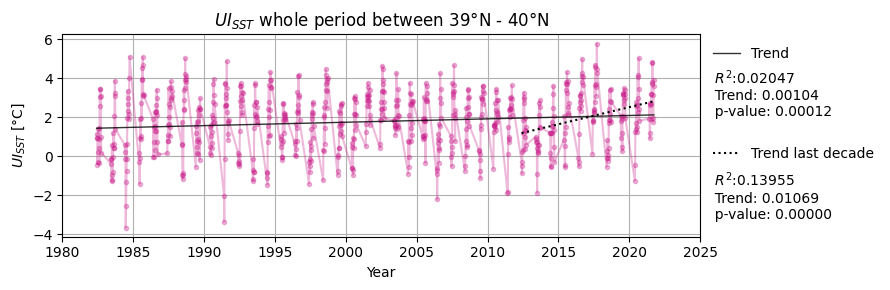

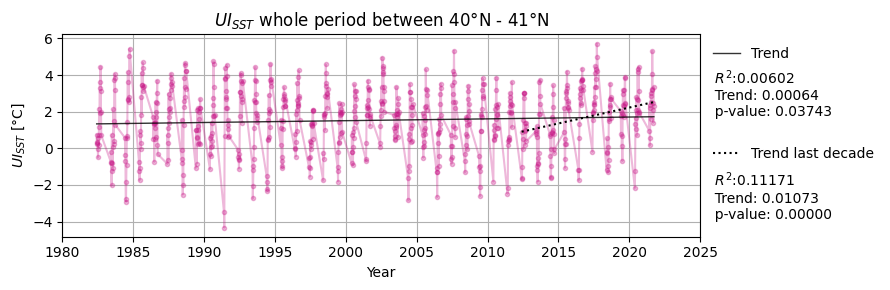

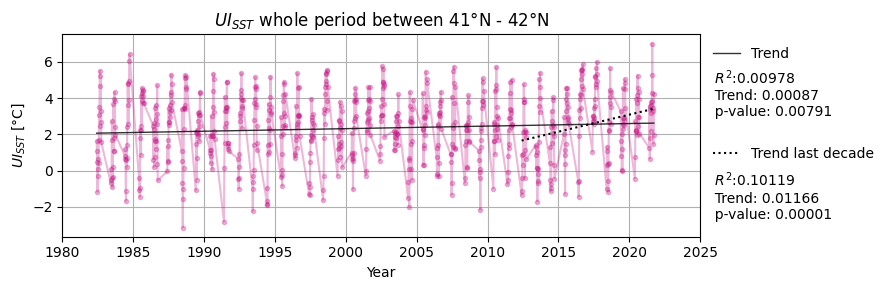

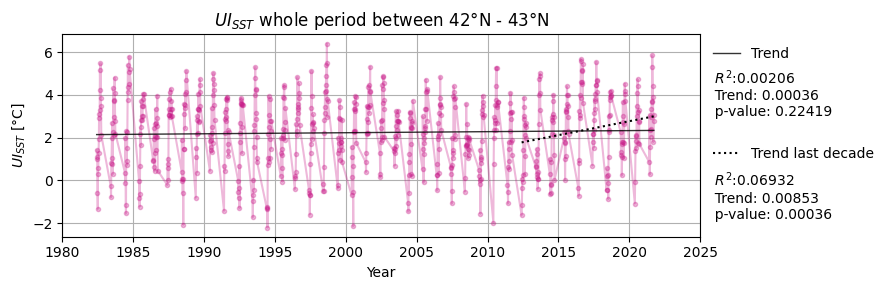

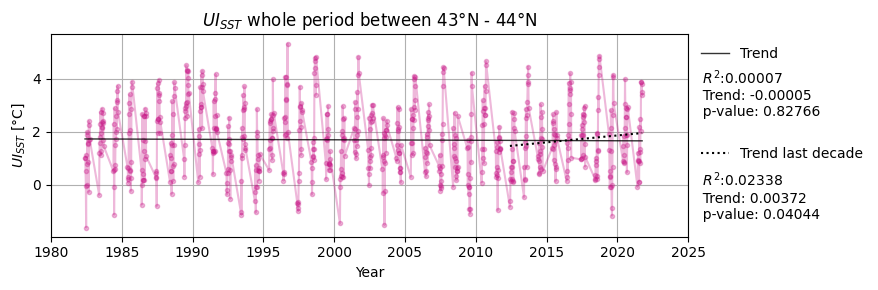

In [320]:
## the summer UI SST for every degree lat (mean around that latitude)
for lats in np.arange(37, 44): # from 44°N coast has more of a SE-NW direction
    y = UI_SST_summer.UI.sel(lon = -10.5, method = 'nearest').sel(lat = slice(lats, lats+1)).mean(dim = 'lat')
    plot_trend(UI_SST_summer.time, y, col = 'mediumvioletred', 
               title = (r'$UI_{SST}$ whole period' f' between {lats}°N - {lats + 1}°N'), ylabel = r'$UI_{SST}$ [°C]') 

### UI<sub>SST</sub> Seasonal mean and anomalies

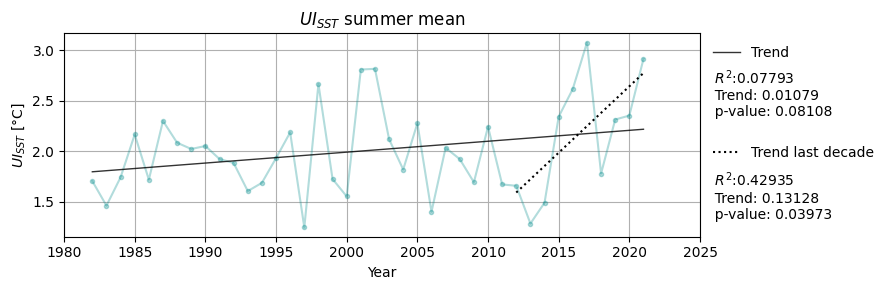

In [321]:
# calculate the mean over the summer months
UI_SST_summer_mean = UI_SST_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
plot_trend(UI_SST_summer_mean.time, UI_SST_summer_mean.UI_mean, title = r'$UI_{SST}$ summer mean', 
           ylabel = r'$UI_{SST}$ [°C]')

Summer mean UI SST 2.008


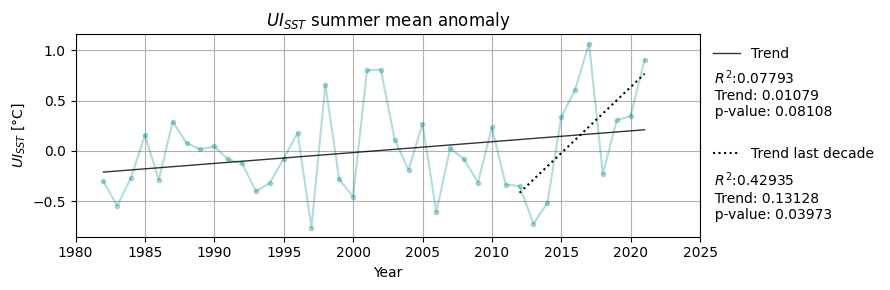

In [325]:
UI_SST_anomaly = UI_SST_summer_mean.UI_mean - UI_SST_summer_mean.UI_mean.mean(dim = 'time')
print('Summer mean UI SST', np.round(UI_SST_summer_mean.UI_mean.mean(dim = 'time').values, 3))
plot_trend(UI_SST_summer_mean.time, UI_SST_anomaly, title = r'$UI_{SST}$ summer mean anomaly', 
           ylabel = r'$UI_{SST}$ [°C]')

## UI<sub>SSH</sub>

## Other

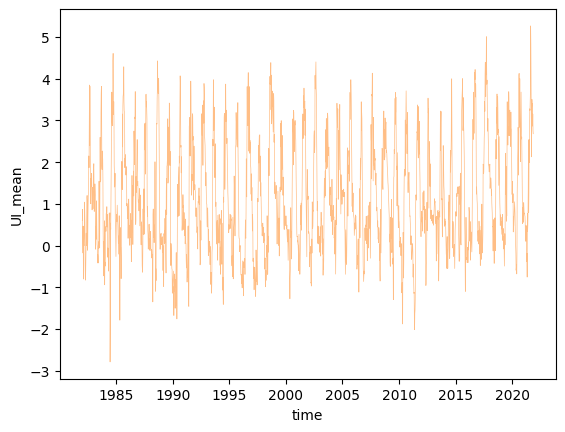

In [60]:
SST.UI_mean.plot(linewidth = 2, alpha = 0.5) # use FilledSST.nc dataset
UI_SST.UI_mean.plot(linewidth = 0.5, alpha = 0.5)